In [47]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [48]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes,
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [49]:
def get_noise(n_samples, z_dim, device):

  return torch.randn((n_samples, z_dim), device=device)

In [50]:
class Generator(nn.Module):

  def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
    super().__init__()
    self.z_dim = z_dim

    self.gen = nn.Sequential(
        # OUTPUT FORMULA H/W = (H/W_in - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1
        # INPUT: (B, C) | B=64, C=10 -> Reshaped to (B, C, H, W) | B=64, C=10, H=1, W=1
        self.make_gen_block(z_dim, hidden_dim * 4),
        # OUTPUT: (B, C, H, W) | B=64, C=256, H=3, W=3
        self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        # OUTPUT: (B, C, H, W) | B=64, C=128, H=6, W=6
        self.make_gen_block(hidden_dim * 2, hidden_dim),
        # OUTPUT: (B, C, H, W) | B=64, C=64, H=13, W=13
        self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)
        # OUTPUT: (B, C, H, W) | B=64, C=1, H=28, W=28
    )

  def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

    if not final_layer:

      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.ReLU(inplace=True)
      )

    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.Tanh()
      )

  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim, 1, 1)
    return self.gen(x)

In [51]:
class Critic(nn.Module):

  def __init__(self, im_chan=1, hidden_dim=64):
    super().__init__()

    self.crit = nn.Sequential(
        # INPUT (B, C, H, W) | B=64, C=1, H=28, W=28
        self.make_crit_block(im_chan, hidden_dim),
        # OUTPUT: (B, C, H, W) | B=64, C=64, H=13, W=13
        self.make_crit_block(hidden_dim, hidden_dim * 2),
        # OUTPUT: (B, C, H, W) | B=64, C=128, H=5, W=5
        self.make_crit_block(hidden_dim * 2, 1, final_layer=True)
        # OUTPUT: (B, C, H, W) | B=64, C=1, H=1, W=1
    )

  def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):

    if not final_layer:

      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.LeakyReLU(0.2, inplace=True)
      )

    else:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride)
      )

  def forward(self, image):
    crit_pred = self.crit(image)
    return crit_pred.view(len(crit_pred), -1)

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [53]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [54]:
def gradient_penalty(gradient):

    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)

    penalty = torch.mean((gradient_norm -1) ** 2)
    return penalty

In [55]:
def get_gradient(crit, real, fake, epsilon):
    """
    Compute the gradient of the critic's scores with respect to mixed images.

    This function is crucial for implementing the gradient penalty in Wasserstein GAN with Gradient Penalty (WGAN-GP).
    It calculates the gradient of the critic's scores with respect to interpolated images between real and fake samples.

    The gradient computation involves a Jacobian-vector product, which is handled implicitly by PyTorch:

    1. mixed_scores is a tensor of shape (batch_size, 1), not a scalar.
    2. torch.autograd.grad with grad_outputs=torch.ones_like(mixed_scores) computes:
       vec⊤ * J, where J is the Jacobian and vec is a vector of ones.
    3. This is equivalent to summing the gradients for each element of the output tensor:
       ∇(s₁ + s₂ + ... + s_batch_size) = ∇s₁ + ∇s₂ + ... + ∇s_batch_size
       where sᵢ are individual scores.

    This approach effectively reduces the computation to something equivalent to a scalar output case,
    resulting in a gradient that has the same shape as the input images. Each element in the resulting
    gradient represents how changing that input pixel would affect the sum of all critic scores.

    Parameters:
    crit (nn.Module): The critic model
    real (torch.Tensor): A batch of real images
    fake (torch.Tensor): A batch of fake images
    epsilon (torch.Tensor): A vector of uniformly random proportions of real/fake per mixed image

    Returns:
    torch.Tensor: The gradient of the critic's scores with respect to the mixed image.
                  Shape matches the input image shape.
    """
    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)

    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]

    return gradient

In [56]:
def get_gen_loss(crit_fake_pred):
    '''
    Calculate the loss for the generator in a Wasserstein GAN (WGAN) framework.

    This loss function is specifically designed for WGANs and differs from traditional GAN loss.
    Instead of using a binary cross-entropy loss (like in traditional GANs), it directly uses
    the critic's scores of fake images.

    Key points:
    1. WGAN Theory: Based on minimizing the Wasserstein distance between real and generated distributions.
    2. Critic vs Discriminator: Uses a critic that estimates Wasserstein distance, not a binary classifier.
    3. Unbounded Output: The critic outputs unbounded real numbers, not probabilities.
    4. Direct Optimization: Aims to maximize the critic's scores for fake images.
    5. Stable Gradients: Provides better gradient behavior throughout training.

    The negative mean is used to frame this as a minimization problem:
    Minimizing -mean(crit_fake_pred) is equivalent to maximizing mean(crit_fake_pred).

    This approach offers several advantages over traditional GAN loss:
    - More stable training
    - Meaningful loss values that correlate with image quality
    - Helps in avoiding mode collapse
    - Better aligns with the theoretical foundations of WGANs

    Parameters:
        crit_fake_pred (torch.Tensor): The critic's scores of the fake (generated) images.
                                       Shape is typically (batch_size, 1).

    Returns:
        gen_loss (torch.Tensor): A scalar tensor representing the generator's loss.
                                 Lower values indicate better performance of the generator.

    Note: This loss is used instead of criterion(crit_fake_pred, torch.ones_like(crit_fake_pred))
          because it better represents the WGAN's objective of minimizing the Wasserstein distance.
    '''
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss


In [57]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Calculate the loss for the critic in a Wasserstein GAN with Gradient Penalty (WGAN-GP) framework.

    This loss function is central to the WGAN-GP architecture and consists of three components:
    1. Wasserstein distance estimation
    2. Gradient penalty
    3. Critic's objective to maximize the difference between real and fake scores

    Key concepts:
    1. Wasserstein Distance: The critic estimates the Wasserstein distance between real and generated distributions.
    2. Earth Mover's Interpretation: The loss can be seen as the cost of transforming the generated distribution to the real distribution.
    3. Gradient Penalty: Enforces the Lipschitz constraint on the critic, crucial for WGAN stability.
    4. No Log Loss: Unlike traditional GANs, there's no log in the loss function, providing better gradients.

    The loss is computed as:
    crit_loss = E[critic(fake_images)] - E[critic(real_images)] + λ * gradient_penalty

    Where:
    - E[critic(fake_images)] is estimated by the mean of crit_fake_pred
    - E[critic(real_images)] is estimated by the mean of crit_real_pred
    - λ (c_lambda) is the gradient penalty coefficient
    - gradient_penalty (gp) ensures the critic function remains 1-Lipschitz

    This formulation aims to:
    - Maximize the difference between scores of real and fake images
    - Ensure the critic function is 1-Lipschitz (through gradient penalty)

    Advantages over traditional GAN critic/discriminator loss:
    - More stable training dynamics
    - Meaningful loss values throughout training
    - Addresses mode collapse issues
    - Provides a more direct measure of generated sample quality

    Parameters:
        crit_fake_pred (torch.Tensor): The critic's scores of the fake (generated) images.
        crit_real_pred (torch.Tensor): The critic's scores of the real images.
        gp (torch.Tensor): The unweighted gradient penalty.
        c_lambda (float): The current weight of the gradient penalty.

    Returns:
        crit_loss (torch.Tensor): A scalar tensor representing the critic's loss.
                                  The critic aims to minimize this value.

    Note: The critic loss is structured to estimate and minimize the Wasserstein
          distance between real and generated distributions, with the gradient
          penalty ensuring the critic adheres to the Lipschitz constraint.
    '''
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp

    return crit_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 5.826775708710775, critic loss: -101.61565491085649


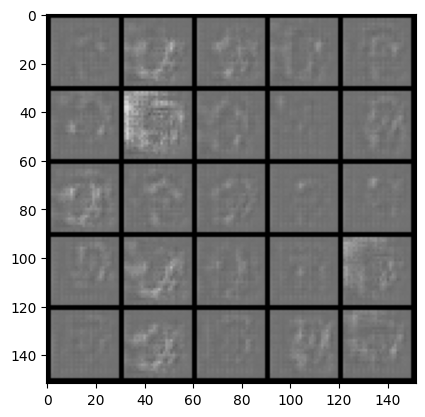

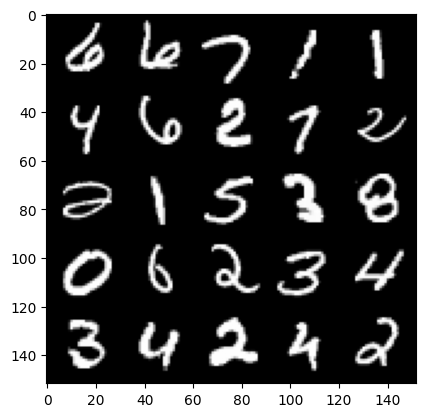

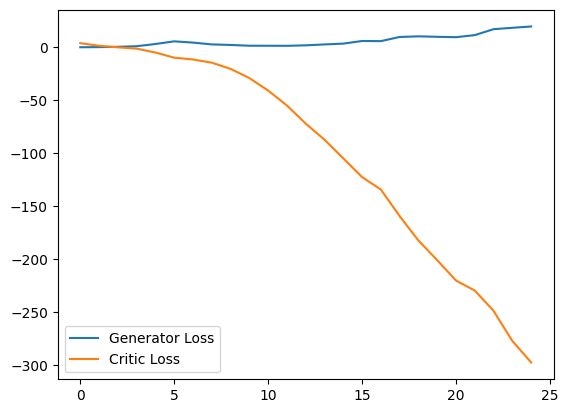

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 11.93102882230282, critic loss: -170.40363377075198


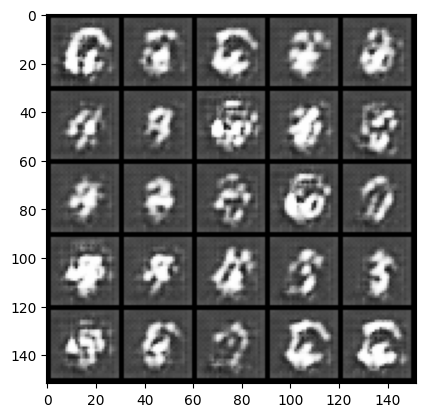

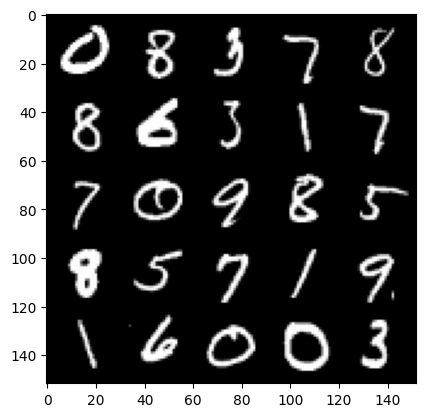

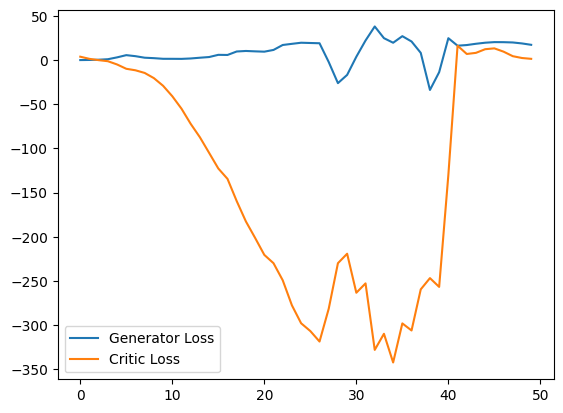

KeyboardInterrupt: 

In [58]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        gen_opt.step()

        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1
